In [1]:
import os
import datetime
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
%matplotlib inline

# 0. Get Data

You can read a description of our data [here](https://quantquote.com/historical-stock-data) under _Free Data_.

In [3]:
sorted(list(filter(lambda f: not f.startswith("."), os.listdir("."))))

['README.md',
 'census_data.csv',
 'data_science_answers.ipynb',
 'data_science_raw.ipynb',
 'duplicates.csv',
 'env',
 'pandas_basics.ipynb',
 'pandas_basics_addntl.ipynb',
 'pandas_basics_answers.ipynb',
 'python_basics.ipynb',
 'python_basics_addntl.ipynb',
 'python_basics_answers.ipynb',
 'quantquote_daily_sp500_83986',
 'requirements.txt',
 'time_series_analysis.ipynb',
 'time_series_analysis_answers.ipynb',
 'y_test.csv']

In [4]:
def get_data(data_url):
    with requests.get(data_url) as r:

        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            z.extractall()

In [5]:
data_url = "http://quantquote.com/files/quantquote_daily_sp500_83986.zip"

In [6]:
get_data(data_url=data_url)

In [7]:
data_dir = os.path.join("quantquote_daily_sp500_83986", "daily")

In [8]:
len(os.listdir(data_dir))

500

### Scope out data directory

In [9]:
stock_csv_names = sorted(os.listdir(data_dir))

In [10]:
len(stock_csv_names)

500

In [11]:
stock_csv_names[:5]

['table_a.csv',
 'table_aa.csv',
 'table_aapl.csv',
 'table_abbv.csv',
 'table_abc.csv']

In [12]:
cols = ['date', 'time', 'open', 'high', 'low_price', 'close', 'volume']

### Look at sample of data

In [13]:
a_df = pd.read_csv(os.path.join(data_dir, stock_csv_names[0]),
                   names=cols)

In [14]:
a_df.shape

(3452, 7)

In [15]:
a_df.head()

,date,time,open,high,low_price,close,volume
0,19991118,0,42.2076,46.3820,37.4581,39.1928,4.398181e+07
1,19991119,0,39.8329,39.8885,36.9293,37.6251,1.139020e+07
2,19991122,0,38.3208,40.0091,37.1613,39.9442,4.654716e+06
3,19991123,0,39.4247,40.4729,37.3375,37.5138,4.268903e+06
4,19991124,0,37.2262,38.9052,37.1056,38.0889,3.602367e+06


In [16]:
a_df.dtypes

date           int64
time           int64
open         float64
high         float64
low_price    float64
close        float64
volume       float64
dtype: object

We see that most of the typing here looks good (no `object` / `string` representations of numeric data) but we do see that `date` is coming in as an `int` rather than a `datetime`. Why is this important? Because, as we will see later, we want our `date` column's values to look, act, and feel like _dates_, as opposed to _integers_.

Also, we see that the `time` column has a value of `0` in the top five rows, and we know that this is _daily_ data - is `time` relevant?

Before we get in to handling these issues, let's continue with our basic data quality checks.

In [17]:
a_df.isnull().sum()

date         0
time         0
open         0
high         0
low_price    0
close        0
volume       0
dtype: int64

In [18]:
a_df.duplicated().sum()

0

Great! No missing data, and no duplicate data.

In [19]:
a_df.date.astype(str).head()

0    19991118
1    19991119
2    19991122
3    19991123
4    19991124
Name: date, dtype: object

The `pandas` library provides a function, `to_datetime`, that will often work to pretty automatically convert a column into `datetime` values. Once in a while, these conversions will require some manual intervention. Let's try this function on our `date` column:

In [20]:
a_df.date = pd.to_datetime(a_df.date.astype(str), infer_datetime_format=True)

In [21]:
a_df.date.head()

0   1999-11-18
1   1999-11-19
2   1999-11-22
3   1999-11-23
4   1999-11-24
Name: date, dtype: datetime64[ns]

Let's check that this is a _proper_ time-series data set, i.e. we're indexed on _time_, which in this case will mean that we have one date for every row:

In [22]:
a_df.date.nunique() / len(a_df)

1.0

Great - we can now set this as our index, which will make many analytical techniques (plotting and joining, for example) easier:

In [23]:
a_df = a_df.set_index("date")

And, `time`:

In [24]:
a_df.time.nunique()

1

In [25]:
a_df = a_df.drop("time", axis=1)

### Problem

Get an _iterable_ of `DataFrames`, one for each stock in our dataset, with the wrangling we did above included.

In [26]:
def get_csv_path(csv_name, stock_csv_folder=data_dir):
    return os.path.join(stock_csv_folder, csv_name)

In [27]:
def get_df(csv_name, cols=cols):
    df = pd.read_csv(get_csv_path(csv_name),
                     names=cols,
                     usecols=list(filter(lambda c: c!= "time", cols)))
    
    df.date = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)

    return df.set_index("date", drop=False)

In [28]:
dfs_iter = (
    get_df(csv_name
    ) for csv_name in stock_csv_names
)

In [29]:
dfs_list = list(dfs_iter)

In [30]:
len(dfs_list)

500

# 1. Prices & Returns

### Prices

In [31]:
aapl_df = get_df("table_aapl.csv")

In [32]:
aapl_df.shape

(3926, 6)

**Note**: we have more rows for `aapl` data than we do for `a`.

In [33]:
pd.Series(aapl_df.index).quantile([0, 1])

0.0   1998-01-02
1.0   2013-08-09
Name: date, dtype: datetime64[ns]

As expected, both `DataFrames` have same end date, but `aapl`'s data starts earlier.

In [34]:
aapl_df.isnull().sum()

date         0
open         0
high         0
low_price    0
close        0
volume       0
dtype: int64

In [35]:
aapl_df.duplicated().sum()

0

Let's take a look at the `aapl` data:

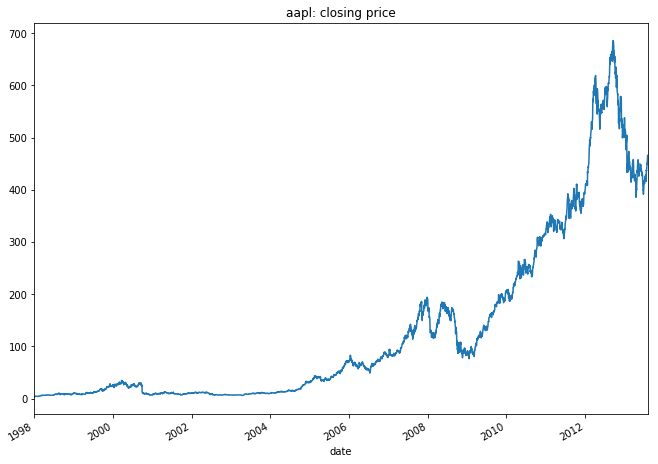

In [36]:
ax = aapl_df.close.plot(figsize=(11, 8))
t = ax.set_title("aapl: closing price")

A couple of observations on the above graph:
- the stock's price has increased over time
- there is a good bit of variability in between the start and end points
- it would have been nice to buy `AAPL` back in the 90s!

We can see clearly that there are a number of different components, if you will, to the above time series:
- there's an upward _trend_ over time
- there look to be some periodic-ish patterns
- there's a fair amount of noise-ish stuff, too

Can we make an attempt to look at these components separately? Yes, this is called [time series decomposition](https://en.wikipedia.org/wiki/Decomposition_of_time_series).

In [37]:
def plot_time_series_decomposition(series, freq=252):
    res = sm.tsa.seasonal_decompose(series, freq=freq)
    
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(11,8))

    p1 = res.trend.plot(ax=ax1, rot=0)
    t1 = ax1.title.set_text("trend")

    p2 = res.seasonal.plot(ax=ax2, rot=0)
    t2 = ax2.title.set_text("seasonal")

    p3 = res.resid.plot(ax=ax3, rot=0)
    t3 = ax3.title.set_text("resid")
    
    fig.tight_layout()

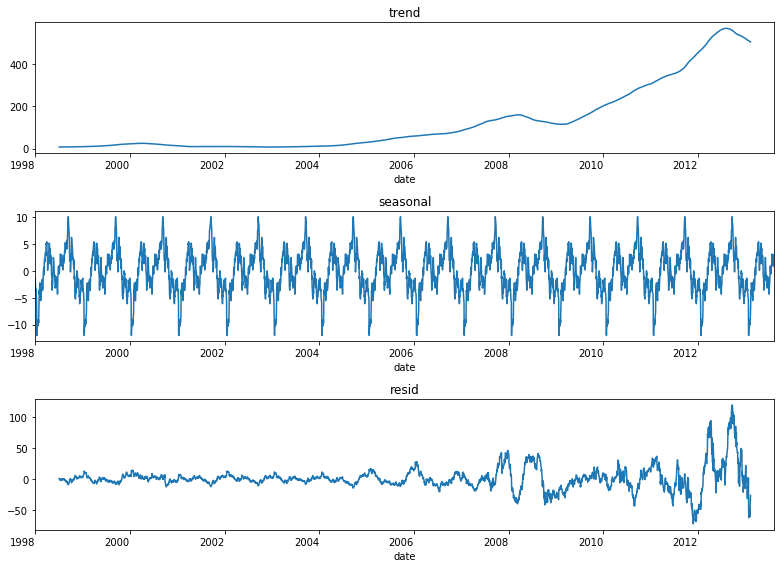

In [38]:
plot_time_series_decomposition(aapl_df.close)

### Returns

Why are returns important? Without getting into too much detail, prices have a _unit root_. You can read more on that [here](https://en.wikipedia.org/wiki/Unit_root). We'll leave this as: you want to be studying the _change_ in a security's price, rather than its _absolute price_.

In [40]:
aapl_df["return_gross"] = aapl_df.close.divide(aapl_df.close.shift(1))

In [41]:
aapl_df["return_simple"] = aapl_df.return_gross - 1

In [42]:
aapl_df.return_simple.describe()

count    3925.000000
mean        0.001672
std         0.029774
min        -0.518150
25%        -0.013670
50%         0.000859
75%         0.016312
max         0.183749
Name: return_simple, dtype: float64

Let's view our returns, _distirbutionally_:

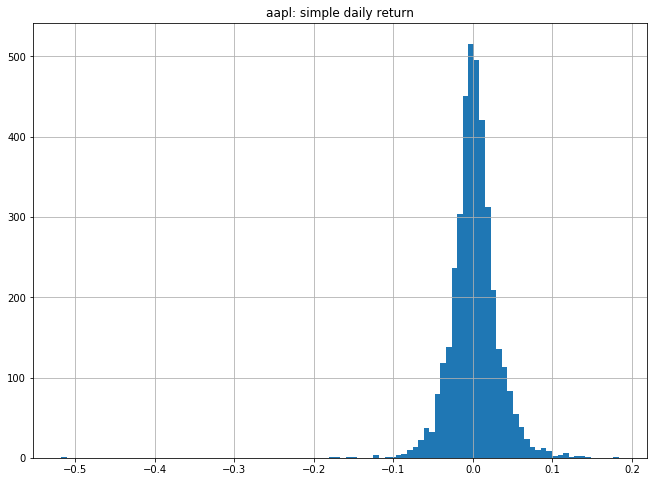

In [43]:
ax = aapl_df.return_simple.hist(figsize=(11, 8), bins=100)

t = ax.set_title("aapl: simple daily return")

Note the long tail stretching out to the left - this data is _negatively skewed_. Let's look more closely into that:

In [44]:
aapl_df.return_simple.quantile([0, .01, .05, .1, .25])

0.00   -0.518150
0.01   -0.070870
0.05   -0.042636
0.10   -0.030308
0.25   -0.013670
Name: return_simple, dtype: float64

In [45]:
(aapl_df.return_simple < -.1).sum()

10

In [46]:
aapl_df[aapl_df.return_simple < -.1]

,date,open,high,low_price,close,volume,return_gross,return_simple
date,,,,,,,,
1999-01-14,1999-01-14,11.06280,11.18440,9.98318,10.07560,5.813583e+07,0.892333,-0.107667
1999-09-21,1999-09-21,17.79520,17.80980,16.77650,16.81050,1.138997e+08,0.875187,-0.124813
2000-09-29,2000-09-29,13.64490,14.10200,12.34160,12.52160,2.339738e+08,0.481850,-0.518150
2000-12-06,2000-12-06,7.11421,7.29413,6.80785,6.99264,4.577349e+07,0.845883,-0.154117
2001-07-18,2001-07-18,10.62510,10.69810,9.92974,10.10480,3.854362e+07,0.829214,-0.170786
2002-06-19,2002-06-19,8.44660,8.55844,8.20832,8.33476,5.893970e+07,0.850621,-0.149379
2002-07-17,2002-07-17,7.84362,7.87766,7.38652,7.62479,4.142656e+07,0.878923,-0.121077
2008-01-23,2008-01-23,132.46100,136.15700,122.67700,135.03800,1.181346e+08,0.880185,-0.119815
2008-09-29,2008-09-29,116.41400,116.41400,97.82880,103.12900,9.250666e+07,0.823352,-0.176648


Now, we can also view our returns _chronologically_:

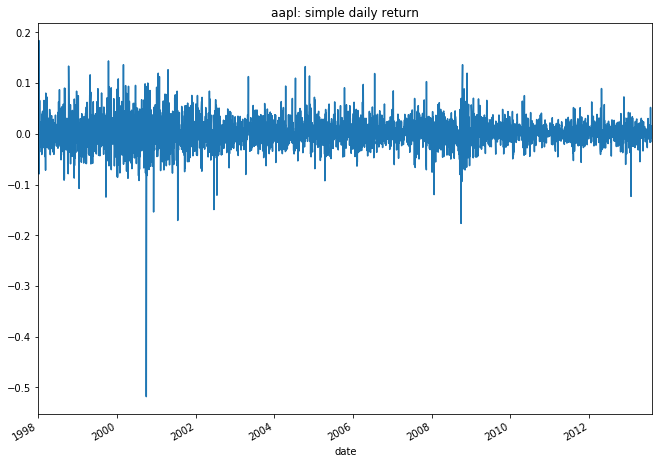

In [47]:
ax = aapl_df.return_simple.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return")

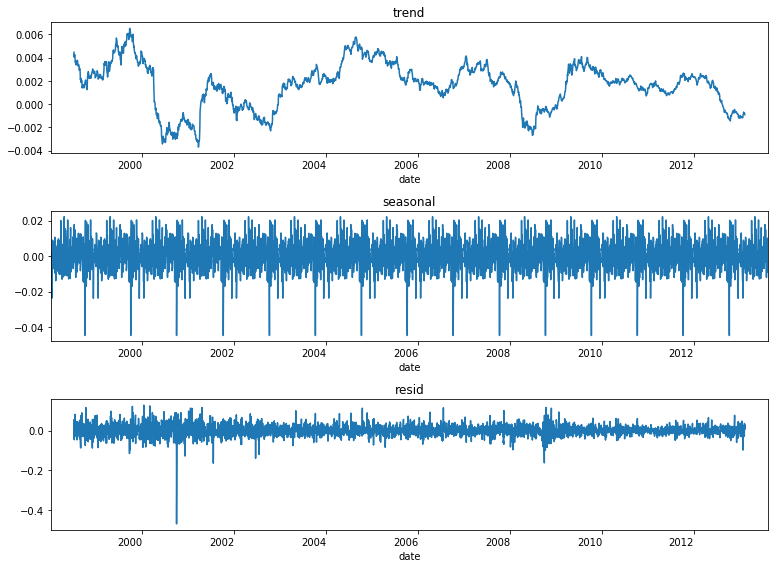

In [48]:
plot_time_series_decomposition(aapl_df.return_simple.dropna())

There's _a lot_ of fluctuation going on here - can we reduce this? Yes we can, through taking a _rolling_ average. We'll start with 21 days (approximately one month's worth of trading days):

In [47]:
aapl_df["return_simple_rolling_21_mean"] = aapl_df.return_simple.rolling(21).mean()

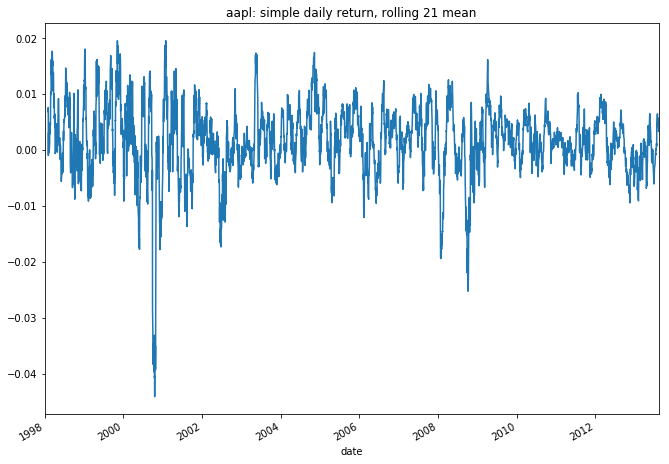

In [48]:
ax = aapl_df.return_simple_rolling_21_mean.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 21 mean")

Let's retain this functionality to try other windows:

In [49]:
def set_and_plot_rolling_mean(window):
    col_name = f"return_simple_rolling_{window}_mean"
    aapl_df[col_name] = aapl_df.return_simple.rolling(window).mean()
    
    ax = aapl_df[col_name].plot(figsize=(11, 8))
    t = ax.set_title(f"aapl: simple daily return, rolling {window} day mean")

How about one quarter?

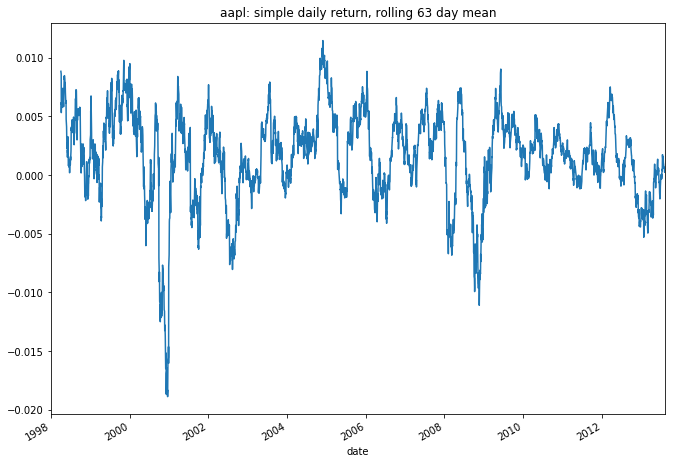

In [50]:
set_and_plot_rolling_mean(63)

Half-year?

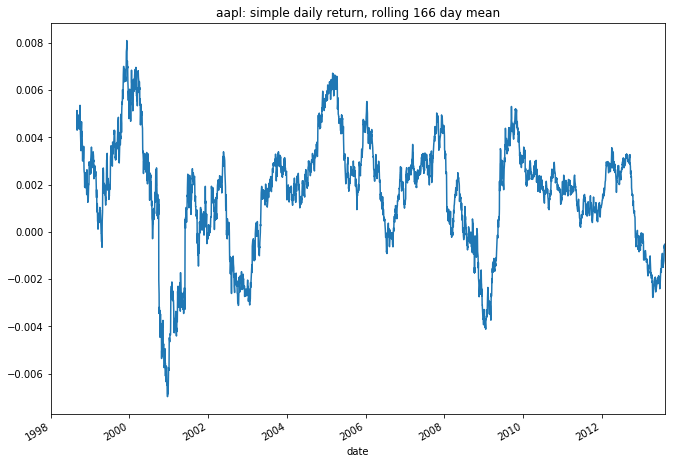

In [51]:
set_and_plot_rolling_mean(166)

Full year?

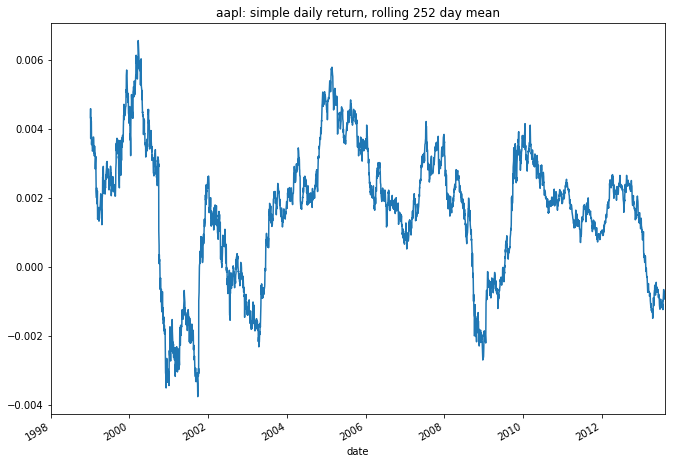

In [52]:
set_and_plot_rolling_mean(252)

Note that our _daily returns_ look to be decreasing over time. Now, how about volatility?

In [53]:
aapl_df["return_simple_63_std"] = aapl_df.return_simple.rolling(63).std()

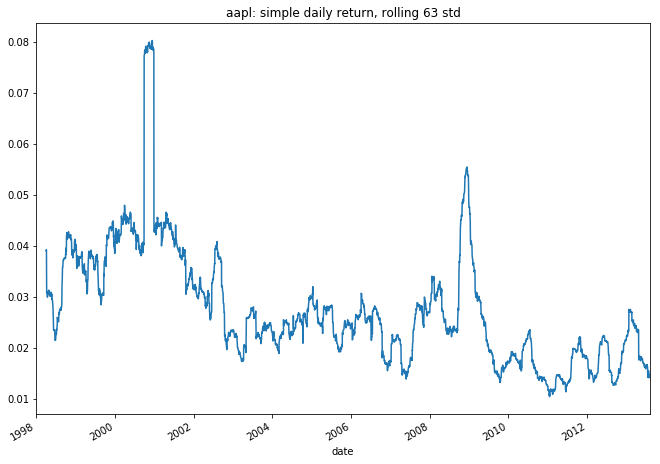

In [54]:
ax = aapl_df.return_simple_63_std.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 63 std")

Let's plot rolling returns and volatility together:

In [55]:
[c for c in aapl_df.columns if "63" in c]

['return_simple_rolling_63_mean', 'return_simple_63_std']

In [56]:
aapl_quarterly = aapl_df[[c for c in aapl_df.columns if "63" in c]
                        ].dropna()

In [57]:
aapl_quarterly = aapl_quarterly / aapl_quarterly.iloc[0]

In [58]:
aapl_quarterly.iloc[0:5]

,return_simple_rolling_63_mean,return_simple_63_std
date,,
1998-04-03,1.000000,1.000000
1998-04-06,0.973895,1.004831
1998-04-07,0.601837,0.829599
1998-04-08,0.699827,0.788331
1998-04-09,0.681255,0.784945


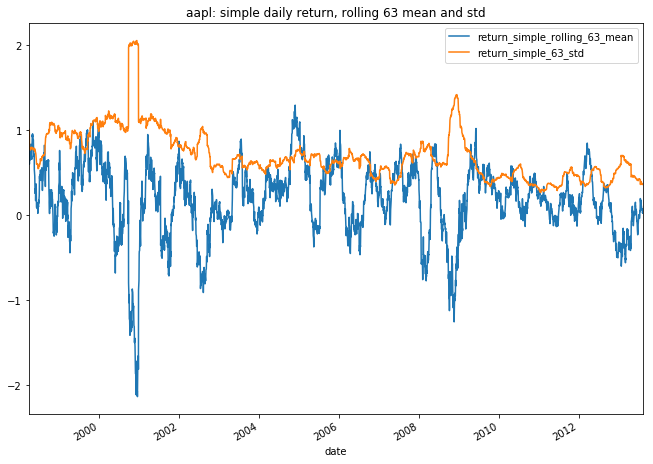

In [60]:
ax = aapl_quarterly.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 63 mean and std")

Note the obvious, inverse relationship between the two:

In [59]:
aapl_quarterly.corr()

,return_simple_rolling_63_mean,return_simple_63_std
return_simple_rolling_63_mean,1.000000,-0.370614
return_simple_63_std,-0.370614,1.000000


Quick check on the beginning of the series:

In [90]:
aapl_quarterly.iloc[0:5]

,return_simple_rolling_63_mean,return_simple_63_std
date,,
1998-04-03,1.000000,1.000000
1998-04-06,0.973895,1.004831
1998-04-07,0.601837,0.829599
1998-04-08,0.699827,0.788331
1998-04-09,0.681255,0.784945


Finally, let's decompose volatility:

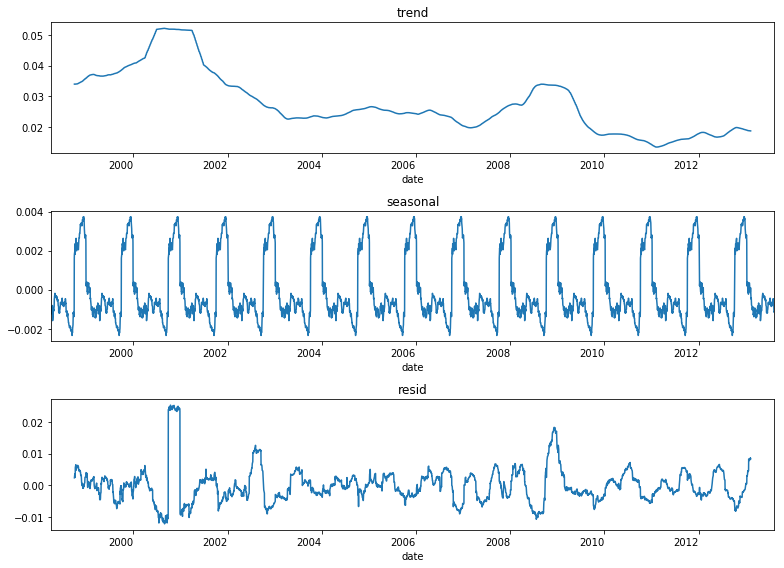

In [61]:
plot_time_series_decomposition(aapl_df.return_simple_63_std.dropna())

### Problem

Compare rolling returns and volatility with differing window lengths and quantify these relationships using _correlation_.

In [61]:
aapl_df[["return_simple_rolling_166_mean", "return_simple_63_std"]].corr()

,return_simple_rolling_166_mean,return_simple_63_std
return_simple_rolling_166_mean,1.000000,-0.280703
return_simple_63_std,-0.280703,1.000000


In [62]:
def compare_return_to_vol(return_col, vol_col, df=aapl_df):
    return df[[return_col, vol_col]].corr()

In [65]:
aapl_df.columns

Index(['date', 'open', 'high', 'low_price', 'close', 'volume', 'return_gross',
       'return_simple', 'return_simple_rolling_21_mean',
       'return_simple_rolling_63_mean', 'return_simple_rolling_166_mean',
       'return_simple_rolling_252_mean', 'return_simple_63_std'],
      dtype='object')

In [66]:
compare_return_to_vol("return_simple_rolling_63_mean", "return_simple_63_std")

,return_simple_rolling_63_mean,return_simple_63_std
return_simple_rolling_63_mean,1.000000,-0.370614
return_simple_63_std,-0.370614,1.000000


In [67]:
aapl_df["return_simple_166_std"] = aapl_df.return_simple.rolling(166).std()

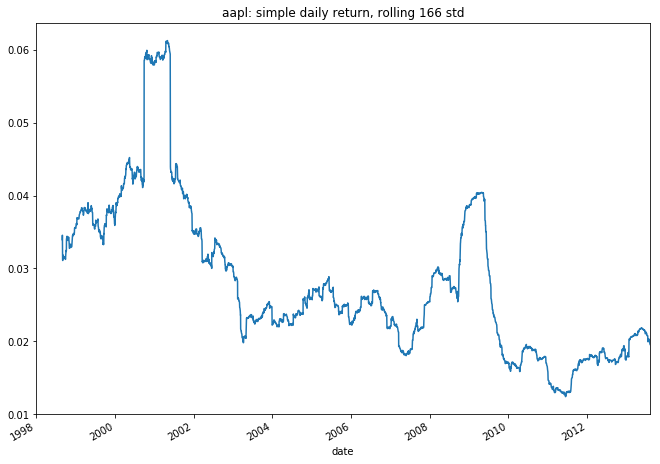

In [68]:
ax = aapl_df.return_simple_166_std.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 166 std")

In [69]:
compare_return_to_vol("return_simple_rolling_166_mean", "return_simple_166_std")

,return_simple_rolling_166_mean,return_simple_166_std
return_simple_rolling_166_mean,1.000000,-0.349501
return_simple_166_std,-0.349501,1.000000


In [70]:
aapl_halflyish = aapl_df[[c for c in aapl_df.columns if "166" in c]
                        ].dropna()

In [72]:
aapl_halflyish = aapl_halflyish / aapl_halflyish.iloc[0]

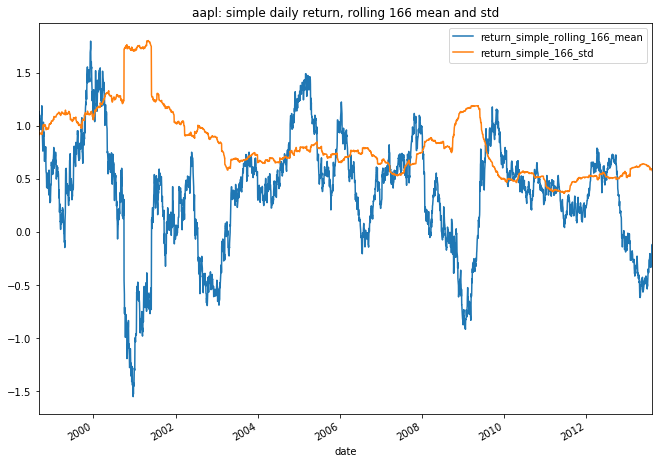

In [73]:
ax = aapl_halflyish.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 166 mean and std")

# Multi-Stock Analysis

### How can we combine all of our stocks into one `DataFrame`?

In [74]:
len(dfs_list)

500

In [76]:
# all_stocks = dfs_list[0].join(dfs_list[1:])

In [77]:
os.listdir(data_dir)[:5]

['table_emc.csv',
 'table_a.csv',
 'table_hal.csv',
 'table_pcar.csv',
 'table_biib.csv']

In [78]:
os.listdir(data_dir)[-5:]

['table_pru.csv',
 'table_lrcx.csv',
 'table_bby.csv',
 'table_key.csv',
 'table_fosl.csv']

In [79]:
def get_stock_name(csv_name):
    file_name = csv_name.split(".")[0]
    return file_name.split("_")[1]

In [80]:
dfs_list_indexed = [
    pd.concat(
        {
            get_stock_name(csv_name): dfs_list[i]
        }, axis=1)
    for i, csv_name in enumerate(stock_csv_names)
]

In [81]:
all_stocks = dfs_list_indexed[0].join(dfs_list_indexed[1:])

In [82]:
all_stocks.iloc[:5, :8]

a                                                     \
                 date     open     high low_price    close        volume   
date                                                                       
1999-11-18 1999-11-18  42.2076  46.3820   37.4581  39.1928  4.398181e+07   
1999-11-19 1999-11-19  39.8329  39.8885   36.9293  37.6251  1.139020e+07   
1999-11-22 1999-11-22  38.3208  40.0091   37.1613  39.9442  4.654716e+06   
1999-11-23 1999-11-23  39.4247  40.4729   37.3375  37.5138  4.268903e+06   
1999-11-24 1999-11-24  37.2262  38.9052   37.1056  38.0889  3.602367e+06   

                   aa           
                 date     open  
date                            
1999-11-18 1999-11-18  24.5183  
1999-11-19 1999-11-19  24.5647  
1999-11-22 1999-11-22  24.6846  
1999-11-23 1999-11-23  25.0018  
1999-11-24 1999-11-24  25.0482

In [83]:
all_stocks["a"].head()

,date,open,high,low_price,close,volume
date,,,,,,
1999-11-18,1999-11-18,42.2076,46.3820,37.4581,39.1928,4.398181e+07
1999-11-19,1999-11-19,39.8329,39.8885,36.9293,37.6251,1.139020e+07
1999-11-22,1999-11-22,38.3208,40.0091,37.1613,39.9442,4.654716e+06
1999-11-23,1999-11-23,39.4247,40.4729,37.3375,37.5138,4.268903e+06
1999-11-24,1999-11-24,37.2262,38.9052,37.1056,38.0889,3.602367e+06


### `close`

In [84]:
all_stocks["a"]["close"].head()

date
1999-11-18    39.1928
1999-11-19    37.6251
1999-11-22    39.9442
1999-11-23    37.5138
1999-11-24    38.0889
Name: close, dtype: float64

In [85]:
tickers = all_stocks.columns.levels[0]

In [86]:
tickers[:5]

Index(['a', 'aa', 'aapl', 'abbv', 'abc'], dtype='object')

In [87]:
_all_close_list = [all_stocks[tick].close for tick in tickers]

In [88]:
_all_close_list[0].head()

date
1999-11-18    39.1928
1999-11-19    37.6251
1999-11-22    39.9442
1999-11-23    37.5138
1999-11-24    38.0889
Name: close, dtype: float64

In [89]:
_all_close_list = [srs.rename(tickers[i])
                  for i, srs in enumerate(_all_close_list)]

In [90]:
all_stocks_close = _all_close_list[0].to_frame().join(_all_close_list[1:])

In [91]:
all_stocks_close.iloc[:5, :8]

,a,aa,aapl,abbv,abc,abt,ace,acn
date,,,,,,,,
1999-11-18,39.1928,24.2514,21.7924,NaN,3.09830,11.9023,14.3008,NaN
1999-11-19,37.6251,24.6846,22.4756,NaN,3.05589,11.8612,13.9294,NaN
1999-11-22,39.9442,25.0250,22.0185,NaN,2.95767,12.2375,14.0259,NaN
1999-11-23,37.5138,25.2185,22.6264,NaN,2.74784,12.0383,13.9294,NaN
1999-11-24,38.0889,24.9283,23.0373,NaN,2.74784,12.1964,13.3722,NaN


In [92]:
all_stocks_returns = all_stocks_close / all_stocks_close.shift(1)

### Correlation

In [93]:
corrs = all_stocks_returns.corr()

In [94]:
corrs.iloc[:5, :5]

,a,aa,aapl,abbv,abc
a,1.000000,0.383146,0.361200,0.164908,0.169508
aa,0.383146,1.000000,0.283109,0.067920,0.254100
aapl,0.361200,0.283109,1.000000,0.032483,0.142794
abbv,0.164908,0.067920,0.032483,1.000000,0.282846
abc,0.169508,0.254100,0.142794,0.282846,1.000000


In [95]:
corrs_modified = corrs.replace(1, np.nan)

In [96]:
corrs_modified.iloc[:5, :5]

,a,aa,aapl,abbv,abc
a,NaN,0.383146,0.361200,0.164908,0.169508
aa,0.383146,NaN,0.283109,0.067920,0.254100
aapl,0.361200,0.283109,NaN,0.032483,0.142794
abbv,0.164908,0.067920,0.032483,NaN,0.282846
abc,0.169508,0.254100,0.142794,0.282846,NaN


In [98]:
corrs_modified.max().sort_values(ascending=False)[:5]

eqr    0.884192
avb    0.884192
spg    0.883757
bxp    0.883757
vno    0.883234
dtype: float64

In [99]:
corrs_modified.min().sort_values(ascending=False)[:5]

wyn    0.178355
pfg    0.175845
dfs    0.175066
dd     0.168540
hst    0.159443
dtype: float64

### Problem

Create a _price index_ that provides insight into the daily tendencies of our 500 stocks. We are going to do this as follows: calculate, for each day, _the mean spread between open and closing prices across all 500 stocks_. 

Next, vizualize your results. Plot on the same axes a the _volatility of the open and closing price spreads_. Note that you may want to _normalize_ prior to plotting.

Additionally, find:
- the 10 days with the highest average open-close spreads
- the 10 days with the highest volatility in their open-close spreads

In [100]:
_all_open_list = [all_stocks[tick].open for tick in tickers]

In [101]:
_all_open_list[0].head()

date
1999-11-18    42.2076
1999-11-19    39.8329
1999-11-22    38.3208
1999-11-23    39.4247
1999-11-24    37.2262
Name: open, dtype: float64

In [102]:
_all_open_list = [srs.rename(tickers[i])
                  for i, srs in enumerate(_all_open_list)]

In [103]:
all_stocks_open = _all_open_list[0].to_frame().join(_all_open_list[1:])

In [104]:
all_stocks_open.iloc[:5, :8]

,a,aa,aapl,abbv,abc,abt,ace,acn
date,,,,,,,,
1999-11-18,42.2076,24.5183,22.1401,NaN,2.88847,12.1775,14.8134,NaN
1999-11-19,39.8329,24.5647,21.7608,NaN,3.08267,12.0003,14.3973,NaN
1999-11-22,38.3208,24.6846,22.3079,NaN,3.01348,12.0193,14.0259,NaN
1999-11-23,39.4247,25.0018,22.3079,NaN,2.95767,12.1585,14.2116,NaN
1999-11-24,37.2262,25.0482,22.6118,NaN,2.73445,12.0794,13.8848,NaN


In [112]:
mean_spread = (all_stocks_close - all_stocks_open
     ).mean(axis=1
     )

In [113]:
mean_spread.head()

date
1999-11-18    0.029497
1999-11-19   -0.136570
1999-11-22   -0.136851
1999-11-23   -0.344567
1999-11-24    0.187926
dtype: float64

In [115]:
mean_spread = mean_spread.rename("mean_spread")

In [116]:
std_spread = (all_stocks_close - all_stocks_open
     ).std(axis=1
     )

In [117]:
std_spread.head()

date
1999-11-18    1.447925
1999-11-19    2.082665
1999-11-22    1.295058
1999-11-23    2.393124
1999-11-24    1.648351
dtype: float64

In [118]:
std_spread = std_spread.rename("std_spread")

In [120]:
joined_spread = mean_spread.to_frame().join(std_spread)

In [121]:
joined_spread = joined_spread / joined_spread.iloc[0]

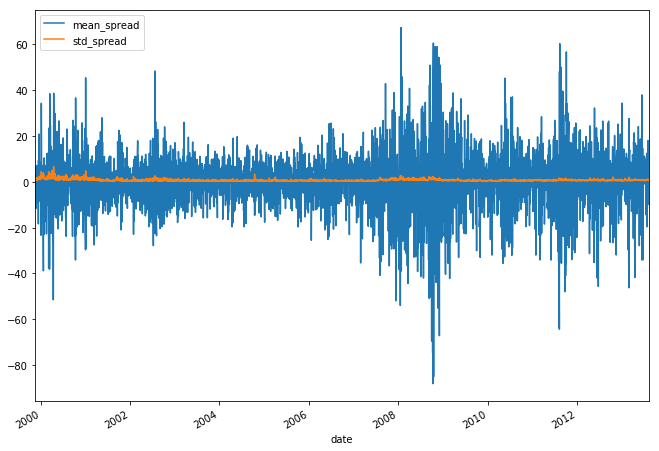

In [123]:
ax = joined_spread.plot(figsize=(11, 8))

# 3. Returns, by Month

Does `AAPL` post better daily performance in certain months?

### Average _daily_ returns, by month

In [124]:
aapl_df["month"] = aapl_df.date.apply(lambda d: d.month)

In [125]:
daily_by_month = aapl_df[["month", "return_simple"]
                         ].groupby("month"
                         ).agg([np.mean, np.std])

In [126]:
daily_by_month

return_simple          
               mean       std
month                        
1          0.002190  0.034613
2          0.001037  0.025793
3          0.003630  0.027720
4          0.002755  0.030354
5         -0.000095  0.025757
6          0.000647  0.024897
7          0.003089  0.030554
8          0.001921  0.023400
9         -0.000956  0.042424
10         0.003242  0.033829
11         0.001369  0.028624
12         0.000834  0.025551

In [127]:
daily_by_month.columns = daily_by_month.columns.droplevel()

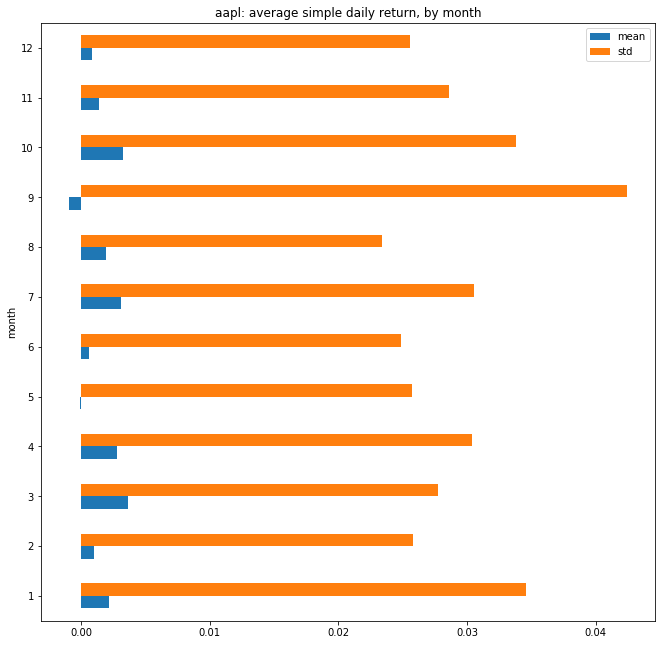

In [128]:
ax = daily_by_month.plot.barh(figsize=(11, 11))

t = ax.set_title("aapl: average simple daily return, by month")

So, we see that, on average, `AAPL` has seen negative daily returns (with higher-than-average volatility) in September - earnings?

### Average _monthly_ returns, by month

In [158]:
aapl_df["year"] = aapl_df.date.apply(lambda d: d.year)

In [174]:
monthly_by_month = aapl_df[["year", "month", "return_simple"]
                         ].groupby(["year", "month"]
                         ).agg([np.amin, np.amax])

In [175]:
monthly_by_month = monthly_by_month.diff(axis=1)

In [176]:
monthly_by_month.columns = monthly_by_month.columns.swaplevel()

In [177]:
monthly_by_month = monthly_by_month["amax"]

In [168]:
monthly_by_month.head()

return_simple
year month               
1998 1           0.262945
     2           0.106502
     3           0.151977
     4           0.089050
     5           0.076243

In [178]:
monthlies = monthly_by_month.groupby(level=1
                      ).agg([np.mean, np.std])

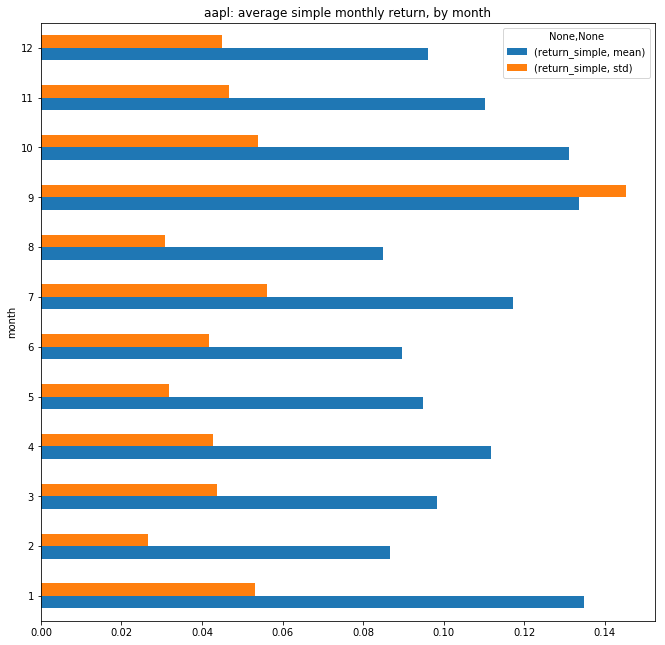

In [170]:
ax = monthlies.plot.barh(figsize=(11, 11))

t = ax.set_title("aapl: average simple monthly return, by month")

### Problem

Calculate the monthly, _volume-weighted_ returns for `AAPL`. Next, aggregate and visualize these values. Finally, in two-three sentences, describe your findings, in particular how they are similar or different to the non-weighted returns calculated above.

In [179]:
monthly_by_month.head()

return_simple
year month               
1998 1           0.262945
     2           0.106502
     3           0.151977
     4           0.089050
     5           0.076243

# 4. Autocorrelation

A quick check is to scatter the data against its immediately preceding points:

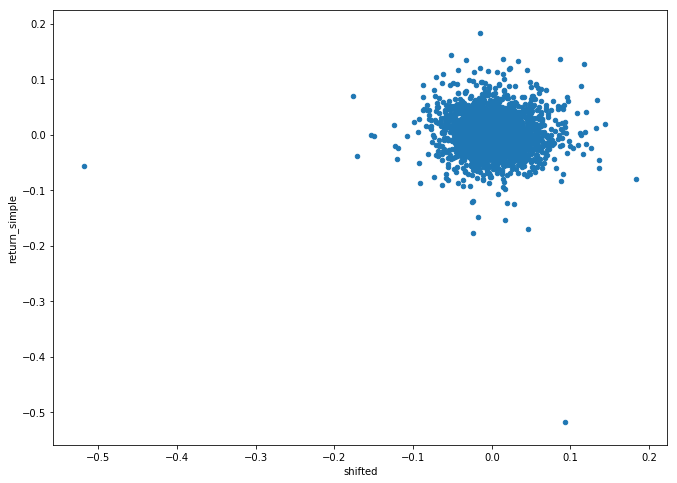

In [181]:
ax = aapl_df.return_simple.to_frame(
            ).join(
                aapl_df.return_simple.shift(1).rename("shifted")
            ).plot.scatter(x="shifted", y="return_simple", figsize=(11, 8))

Let's scrub the outlier and try again:

In [182]:
t_and_t_plus_one = aapl_df.return_simple.to_frame(
                         ).join(
                             aapl_df.return_simple.shift(1).rename("shifted")
                         )

In [183]:
(t_and_t_plus_one < -.5).sum()

return_simple    1
shifted          1
dtype: int64

In [184]:
for col in t_and_t_plus_one.columns:
    t_and_t_plus_one.loc[t_and_t_plus_one[col] < -.5, col] = np.nan

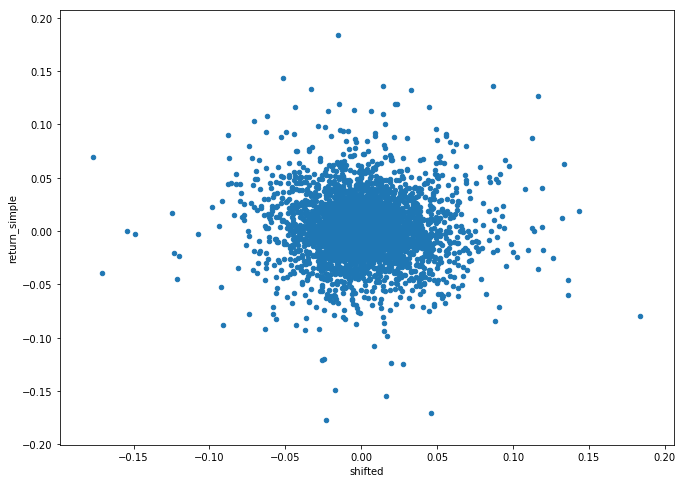

In [185]:
ax = t_and_t_plus_one.plot.scatter(x="shifted", y="return_simple", figsize=(11, 8))

Now, let's look at _autocorrelation_ over differing `shift` values (i.e. differing _lags_):

In [186]:
[str(x) for x in range(5)]

['0', '1', '2', '3', '4']

In [187]:
{str(x):x for x in range(5)}

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [188]:
aapl_autocorrs = pd.Series({
            lag: aapl_df.return_simple.autocorr(lag=lag) for lag in list(range(1, 20))
            })

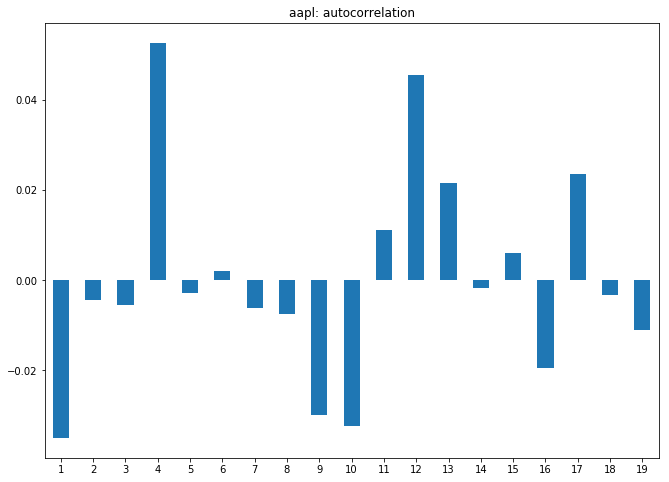

In [189]:
ax = aapl_autocorrs.plot.bar(figsize=(11, 8), rot=0)

t = ax.title.set_text("aapl: autocorrelation")

What do we see here? Note that `4 lags` is equivalent to one week behind.

### Problem

Extract the most signification `lag` values from above, and understand whether day-of-the-week makes a difference.

In [190]:
aapl_df["weekday"] = aapl_df.date.apply(lambda d: d.weekday())

In [191]:
aapl_df.weekday.value_counts(normalize=True).sort_index()

0    0.187723
1    0.204534
2    0.205807
3    0.201732
4    0.200204
Name: weekday, dtype: float64

In [194]:
aapl_df[aapl_df.weekday == 4].return_simple.head()

date
1998-01-02         NaN
1998-01-09    0.010519
1998-01-16   -0.022928
1998-01-23    0.009838
1998-01-30   -0.009699
Name: return_simple, dtype: float64

In [195]:
aapl_df[aapl_df.weekday == 4].return_simple.autocorr(lag=1)

0.06890856162364505

In [196]:
for w in sorted(aapl_df.weekday.unique()):
    print(w, aapl_df[aapl_df.weekday == w].return_simple.autocorr(lag=1), sep=": ")

0: 0.03307978683299215
1: 0.021425472719051118
2: 0.011322729304048993
3: -0.025362416692087084
4: 0.06890856162364505


### Correlations, with rolling window returns

In [197]:
aapl_df.return_simple.to_frame(
                    ).join(
                        aapl_df.return_simple_rolling_21_mean.shift(1)
                    ).corr()

,return_simple,return_simple_rolling_21_mean
return_simple,1.000000,-0.004471
return_simple_rolling_21_mean,-0.004471,1.000000


In [198]:
aapl_df.return_simple.to_frame(
                    ).join(
                        aapl_df.return_simple_rolling_63_mean.shift(1)
                    ).corr()

,return_simple,return_simple_rolling_63_mean
return_simple,1.00000,0.01565
return_simple_rolling_63_mean,0.01565,1.00000


Interesting: ~1.6% is not _huge_, but this is also noticeable (at least compared to the results for the 21-day window.

### Problem

Loop through all possible rolling windows (from 2 days to 1 year on `aapl_df.return_simple`, and for each:
- get `mean` and and `std` for each
- `shift` by 1
- then calculate the correlation between these shifted values and `aapl_df.return_simple`
- retain results

Visualize the top 5 (in magnitude). Bonus points for code elegance (funcional one-liners are a personal favorite of mine) and visualization creativity.

# 5. Log Returns

Taking the logarithm of prices allows for _easy_ returns calculations. Additionally, taking the log of a data set can squeeze in outliers and reduce skewness:

In [199]:
aapl_df["close_log"] = aapl_df.close.apply(np.log)

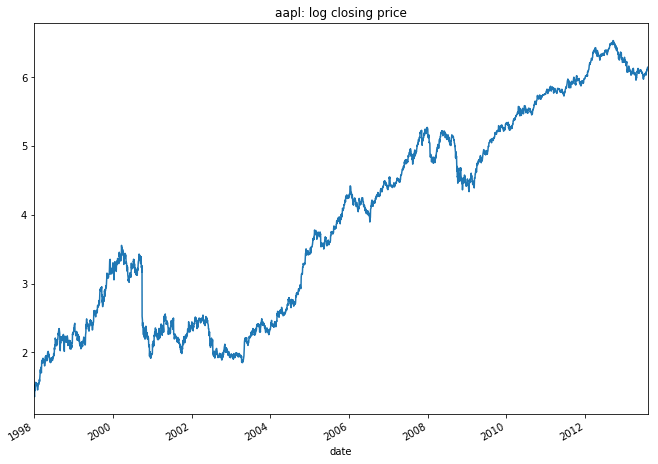

In [200]:
ax = aapl_df.close_log.plot(figsize=(11, 8))
t = ax.set_title("aapl: log closing price")

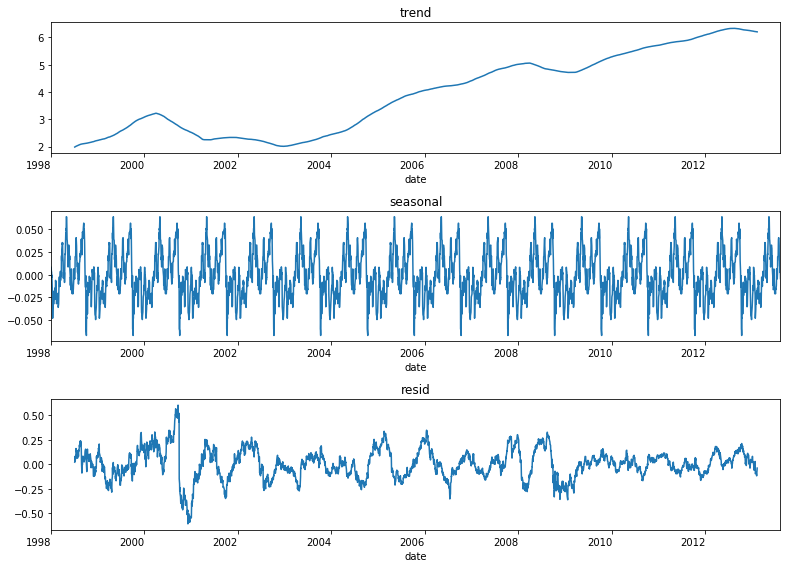

In [201]:
plot_time_series_decomposition(aapl_df.close_log)

In [202]:
aapl_df["return_log"] = aapl_df.close_log - aapl_df.close_log.shift(1)

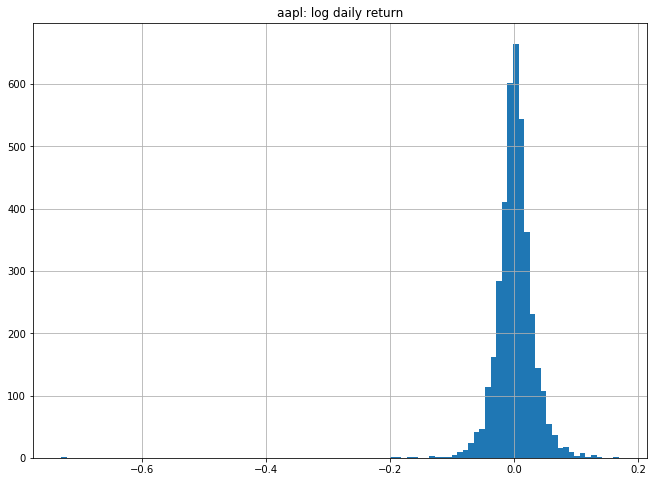

In [203]:
ax = aapl_df.return_log.hist(figsize=(11, 8), bins=100)

t = ax.set_title("aapl: log daily return")

In [204]:
aapl_df.return_simple.skew()

-1.198448451367238

In [205]:
aapl_df.return_log.skew()

-3.4413935608928203

One thing that I personally like to do when I have skewed data with negative values is to take the _cube root_ of it:

In [206]:
aapl_df["return_cubrt"] = aapl_df.return_simple.apply(np.cbrt)

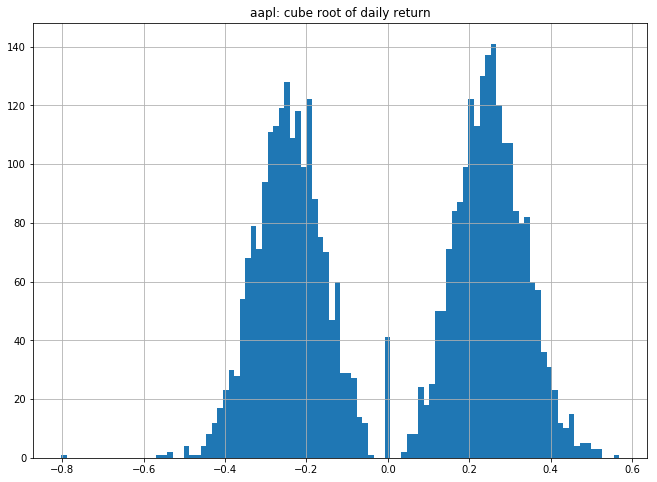

In [207]:
ax = aapl_df.return_cubrt.hist(figsize=(11, 8), bins=100)

t = ax.set_title("aapl: cube root of daily return")

We've separated out the positive and negative values, and it's interesting to look at each group's frequencies separately. Any ideas on how we could get at the underlying separation?

In [136]:
aapl_df["day_of_week"] = aapl_df.date.apply(lambda d: d.weekday())

In [138]:
aapl_df.day_of_week.value_counts(normalize=True).sort_index()

0    0.187723
1    0.204534
2    0.205807
3    0.201732
4    0.200204
Name: day_of_week, dtype: float64

In [139]:
aapl_df["is_monday"] = aapl_df.day_of_week == 0

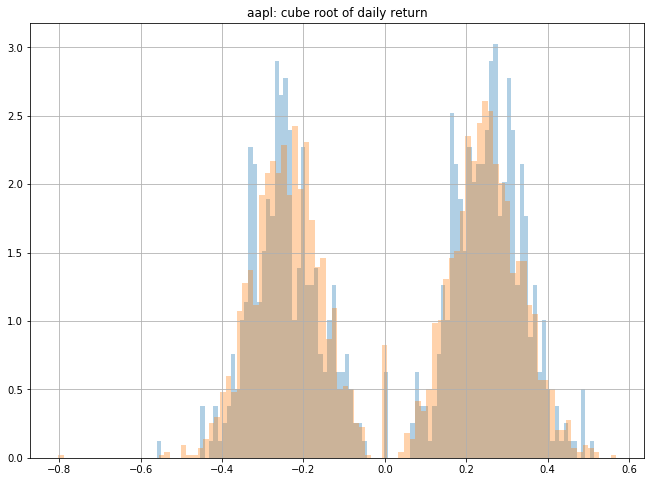

In [147]:
ax = aapl_df.loc[aapl_df.is_monday == True, "return_cubrt"].hist(
                    figsize=(11, 8), bins=100, density=True, alpha=.35)

ax = aapl_df.loc[aapl_df.is_monday == False, "return_cubrt"].hist(ax=ax, alpha=.35, bins=100, density=True)

t = ax.set_title("aapl: cube root of daily return")

In [148]:
aapl_df[["return_simple", "is_monday"]].groupby("is_monday").agg([np.mean, np.std])

return_simple          
                   mean       std
is_monday                        
False          0.001286  0.029905
True           0.003341  0.029161

# 6. Autoregression

In [208]:
aapl_returns_2010 = aapl_df.loc[aapl_df.date.apply(lambda d: d.year == 2010), "return_simple"]

In [209]:
train = aapl_returns_2010.loc[:datetime.date(2010, 6, 30)]

In [210]:
train.head()

date
2010-01-04    0.016518
2010-01-05    0.000701
2010-01-06   -0.016521
2010-01-07   -0.001990
2010-01-08    0.007175
Name: return_simple, dtype: float64

In [211]:
train.tail()

date
2010-06-24   -0.006807
2010-06-25   -0.005433
2010-06-28    0.005089
2010-06-29   -0.044515
2010-06-30   -0.020156
Name: return_simple, dtype: float64

In [212]:
test = aapl_returns_2010.loc[datetime.date(2010, 7, 1):datetime.date(2010, 7, 31)]

In [213]:
model = AR(train.values)

In [214]:
model_fit = model.fit()

In [216]:
model_fit.k_ar

13

In [217]:
model_fit.params

array([ 0.00246467,  0.04125616,  0.03683962, -0.25484031,  0.04155076,
        0.09983197, -0.17533004, -0.02235045, -0.07667173, -0.08510721,
       -0.01421416, -0.03022782,  0.04335507,  0.29210439])

In [218]:
params_df = pd.DataFrame(model_fit.params,
                         index=[i for i in range(len(model_fit.params))],
                         columns=["model_params"])

In [219]:
autocorrs = aapl_autocorrs.rename("autocorr").loc[:13].to_frame()

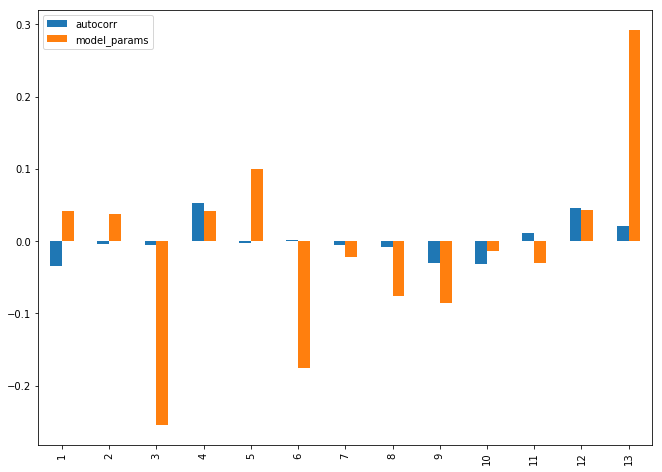

In [220]:
ax = autocorrs.join(params_df).plot.bar(figsize=(11, 8))

In [221]:
predictions = model_fit.predict(start=len(train),
                                end=len(train) + len(test) -1,
                                dynamic=False)

In [222]:
predictions_df = pd.DataFrame(predictions, index=test.index, columns=["predicted"])

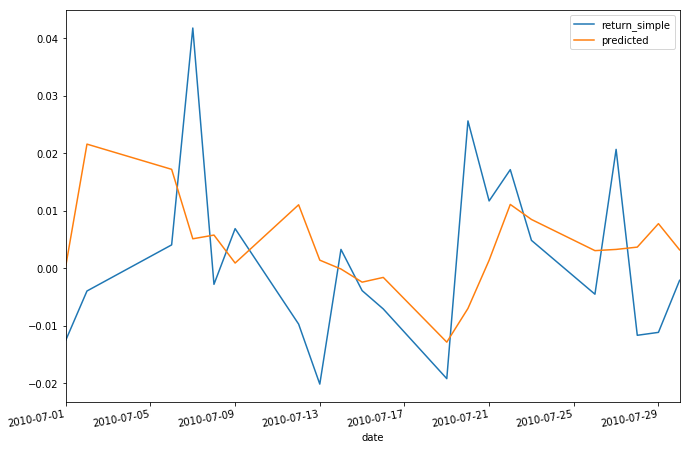

In [223]:
ax = test.to_frame().join(predictions_df).plot(figsize=(11, 8), rot=10)

### Problem

Find 5, 7-month periods, and replicate this experiment over these periods (6 months for training, 1 month for test). Code this out so that the core modeling and results handling is done programmatically / iteratively (i.e. don't hardcode). Describe your findings.